In [314]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [315]:
import os
import numpy as np
import tqdm
import time
import pathlib

import tensorflow as tf

from scrinet.fits.nn import RegressionANN

In [316]:
import schwimmbad
import functools
import tqdm

In [317]:
# import sys
# sys.path.append("/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline")
from pipe_utils import init_logger, load_data

In [318]:
from evaluate_model import match, wave_sur_many, load_model

In [319]:
import generators

In [320]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
def upsample(x, y, npts=None):
    new_x = np.linspace(x[0], x[-1], npts)
    iy = IUS(x, y)
    return new_x, iy(new_x)

def resample(x, y, new_x):
    iy = IUS(x, y)
    return new_x, iy(new_x)

In [321]:
def wave_sur_many(qs, chis, amp_model, amp_basis, phase_model, phase_basis, times=None):
    
    default_times = np.linspace(-10000, 100, 5000)
    if times is not None:
        #resample basis
        new_amp_basis = np.zeros(shape=(amp_basis.shape[0], len(times)))
        for i in range(amp_basis.shape[0]):
            _, new_amp_basis[i] = resample(default_times, amp_basis[i], times)
        amp_basis = new_amp_basis
            
        new_phase_basis = np.zeros(shape=(phase_basis.shape[0], len(times)))
        for i in range(phase_basis.shape[0]):
            _, new_phase_basis[i] = resample(default_times, phase_basis[i], times)
        phase_basis = new_phase_basis
    else:
        times = default_times
    
    pars = np.array(list(zip(qs, chis)))
    pars[:,0] = np.log(pars[:,0]) # need to log the mass-ratio

    amp_alpha = amp_model.predict(pars)
    amp = np.dot(amp_alpha, amp_basis)

    phase_alpha = phase_model.predict(pars)
    phase = np.dot(phase_alpha, phase_basis)

    h = amp * np.exp(-1.j * phase)

    return np.real(h), np.imag(h), amp, phase, times

In [322]:
pwd

'/nfshome/store01/users/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/test-run'

In [323]:
rootdir = '/home/sebastian.khan/git/stk/scrinet/bin/dev/pipeline/test-run/run'

In [324]:
amp_basis = os.path.join(rootdir, 'rb/amp/amp_eim_basis.npy')
amp_model_dir = os.path.join(rootdir, 'ts/amp/fits')

phase_basis = os.path.join(rootdir, 'rb/phase/phase_eim_basis.npy')
phase_model_dir = os.path.join(rootdir, 'ts/phase/fits')

In [325]:
amp_model, amp_basis = load_model(
    basis_file=amp_basis,
    nn_weights_file=os.path.join(amp_model_dir, "best.h5"),
    X_scalers_file=os.path.join(amp_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(amp_model_dir, "Y_scalers.npy"))

phase_model, phase_basis = load_model(
    basis_file=phase_basis,
    nn_weights_file=os.path.join(phase_model_dir, "best.h5"),
    X_scalers_file=os.path.join(phase_model_dir, "X_scalers.npy"),
    Y_scalers_file=os.path.join(phase_model_dir, "Y_scalers.npy"))

In [391]:
qs = [2]
chis = [0.90]

In [424]:
# %%timeit
ts_times, ts_amp, ts_phase, ts_freq, coords = \
    generators.gen_2d_massratio_chi_data(qs, chis, 60, 1, deltaT=1./1024., npts=5000*10)
ts_hp = np.real(ts_amp * np.exp(-1.j * ts_phase))

2.15 s ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [393]:
ts_hp.shape

(1, 50000)

In [427]:
# %%timeit
sur_hp, sur_hc, samp, sphase, sur_times = wave_sur_many(coords[:,0], coords[:,1], amp_model, amp_basis, phase_model, phase_basis, ts_times)

69.1 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [426]:
2.15/506e-3

4.24901185770751

In [428]:
2.15/70e-3

30.71428571428571

In [395]:
sur_hp.shape

(1, 50000)

In [396]:
ts_times.shape

(50000,)

In [397]:
sur_times.shape

(50000,)

(-100, 100)

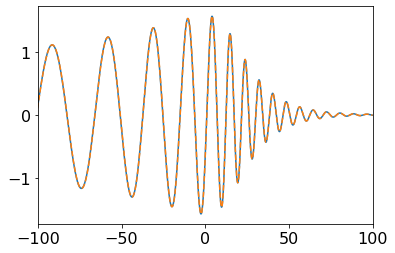

In [398]:
plt.figure()
plt.plot(ts_times, ts_hp[0])
plt.plot(ts_times, sur_hp[0], ls='--')
plt.xlim(-100,100)

In [399]:
mask = ts_times > -1000
maxmatch = np.max(np.abs(match(ts_hp[0][mask], sur_hp[0][mask], ts_times[mask])))
print(maxmatch)

0.9999652919090485


In [400]:
maxmatch = np.max(np.abs(match(ts_hp[0], sur_hp[0], ts_times)))
print(maxmatch)

0.9999647906552027


(-1000, 100)

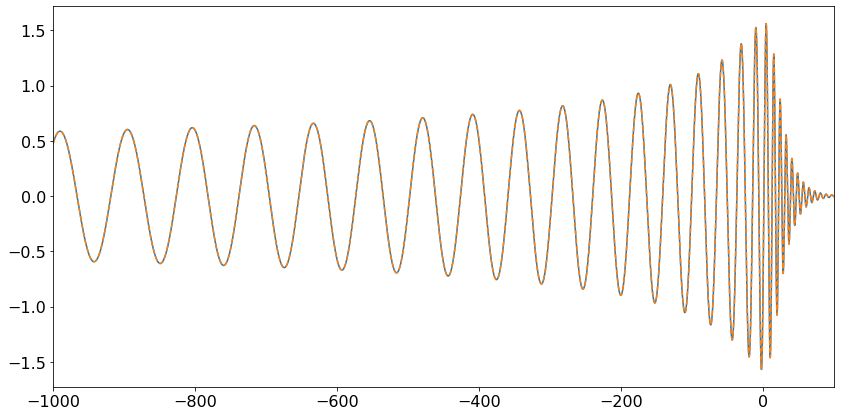

In [402]:
plt.figure(figsize=(14, 7))
plt.plot(ts_times, ts_hp[0])
plt.plot(ts_times, sur_hp[0], ls='--')
plt.xlim(-1000,100)

(-100, 100)

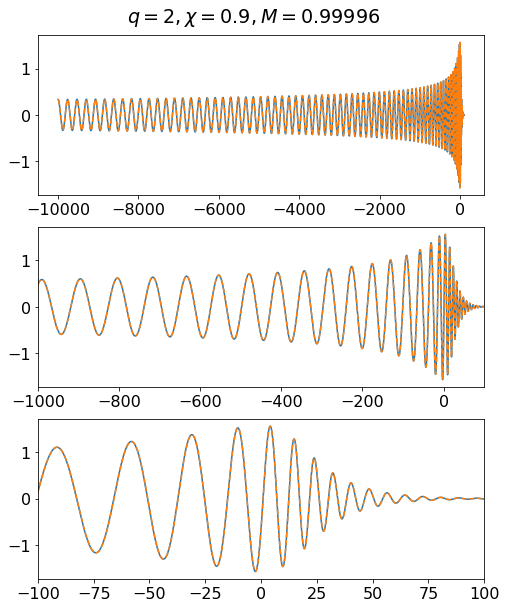

In [423]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
fig.suptitle(fr"$q = {qs[0]}, \chi = {chis[0]}, M = {maxmatch:.5f}$", y=0.92)
for ax in axes:
    ax.plot(ts_times, ts_hp[0])
    ax.plot(ts_times, sur_hp[0], ls='--')
axes[1].set_xlim(-1000,100)
axes[2].set_xlim(-100,100)
# plt.xlim(-1000,100)
# plt.title(fr"q = {qs[0]}, \chi = {chis[0]}")

(-100, 100)

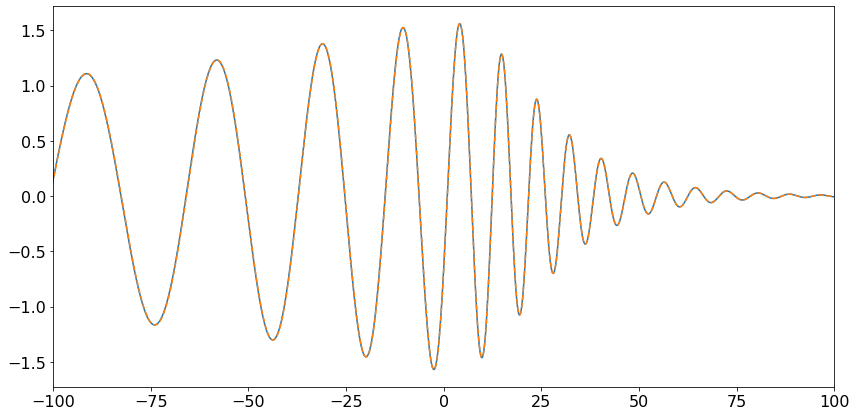

In [337]:
plt.figure(figsize=(14, 7))
plt.plot(ts_times, ts_hp[0])
plt.plot(ts_times, sur_hp[0], ls='--')
plt.xlim(-100,100)
# plt.xlim(-1000,100)

(-100, 100)

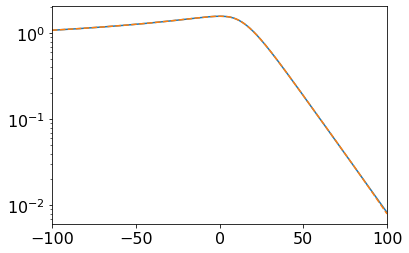

In [338]:
plt.figure()
plt.plot(ts_times, ts_amp[0])
plt.plot(ts_times, samp[0], ls='--')
plt.yscale('log')
plt.xlim(-100,100)

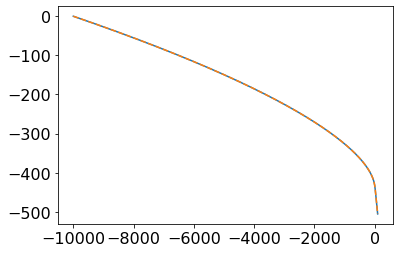

In [339]:
plt.figure()
plt.plot(ts_times, ts_phase[0])
plt.plot(ts_times, sphase[0], ls='--')
# plt.xlim(-100,100)

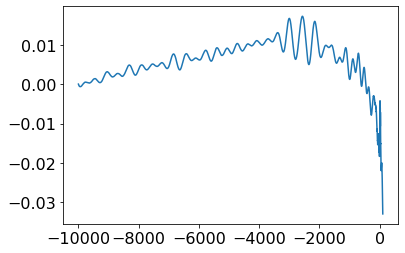

In [340]:
plt.figure()
plt.plot(ts_times, ts_phase[0]-sphase[0])
# plt.xlim(-100,100)

# grid up approach

In [355]:
# make true signal

q_true = [3]
chi_true = [0.345]

true_ts_times, true_ts_amp, true_ts_phase, true_ts_freq, true_coords = \
    generators.gen_2d_massratio_chi_data(q_true, chi_true, 60, 1, deltaT=1./1024., npts=5000*10)
true_ts_hp = np.real(true_ts_amp * np.exp(-1.j * true_ts_phase))
true_ts_hp = true_ts_hp[0]

In [342]:
%%timeit
true_ts_times, true_ts_amp, true_ts_phase, true_ts_freq, true_coords = \
    generators.gen_2d_massratio_chi_data(q_true, chi_true, 60, 1, deltaT=1./1024., npts=5000*10)

2.06 s ± 99.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'true signal')

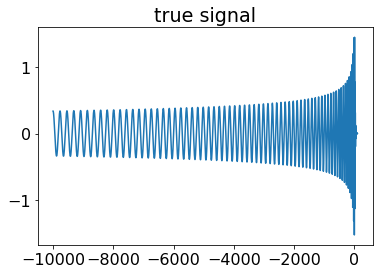

In [343]:
plt.figure()
plt.plot(true_ts_times, true_ts_hp)
plt.title("true signal")

In [372]:
q_1d = np.linspace(1, 8, 80)
chi_1d = np.linspace(-1,1, 80)
# q_1d = np.linspace(1, 8, 10)
# chi_1d = np.linspace(-1,1, 10)
qq, cc = np.meshgrid(q_1d, chi_1d)
qq = qq.ravel()
cc = cc.ravel()
print(f"{len(qq)} waveforms")

6400 waveforms


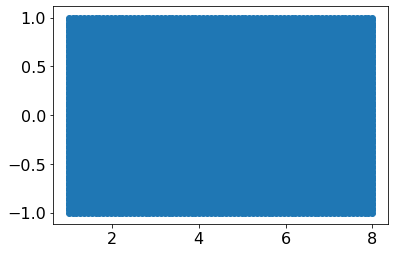

In [373]:
plt.figure()
plt.scatter(qq, cc)

In [374]:
print("running the search")
t1 = time.time()
sur_hp, sur_hc, samp, sphase, sur_times = wave_sur_many(qq, cc, amp_model, amp_basis, phase_model, phase_basis, true_ts_times)
t2 = time.time()
dt = t2-t1
print(f"generated {len(qq)} waveforms took: {dt:.2f}s")
print(f"time per waveform: {dt/len(qq):.5f} s")

# serial match version
# print("running matches")
# matches = []
# for i in tqdm.tqdm(range(len(qq))):
#     maxmatch = np.max(np.abs(match(true_ts_hp, sur_hp[i], true_ts_times)))
#     matches.append(maxmatch)
# matches = np.array(matches)
# max_match_idx = matches.argmax()
# max_params = dict(q=qq[max_match_idx], chi=cc[max_match_idx])
# print("max params:")

# print(f"q = {max_params['q']}, chi = {max_params['chi']}")

running the search
generated 6400 waveforms took: 53.22s
time per waveform: 0.00832 s


In [375]:
#parallel match version

n_cores = 20
tasks = list(sur_hp)

# here a task is a surrogate waveform - it is faster to parallelise this rather than mapping over the index of the array
# probably because there is a lot of overhead to pass the data
def worker_match(task, data, times):
    maxmatch = np.max(np.abs(match(data, task, times)))
    return maxmatch

worker_match_partial = functools.partial(worker_match, data=true_ts_hp, times=true_ts_times)

print("running matches")
print(f"using {n_cores} cores")

t1 = time.time()
if n_cores == 1:
    pool = gen_wf_data.SinglePool()
else:
    pool = schwimmbad.choose_pool(mpi=False, processes=n_cores)
matches = pool.map(worker_match_partial, tasks)
try:
    pool.close
except AttributeError:
    pass
t2 = time.time()
dt = t2-t1
print(f"computed matches in: {dt:.2f}s")

matches = np.array(matches)
max_match_idx = matches.argmax()
max_params = dict(q=qq[max_match_idx], chi=cc[max_match_idx])
print("max params:")
print(f"q = {max_params['q']}, chi = {max_params['chi']}")

running matches
using 20 cores
computed matches in: 19.80s
max params:
q = 2.9493670886075947, chi = 0.36708860759493667


In [383]:
print(f"max match: {matches[max_match_idx]}")

max match: 0.9921553658525909


In [384]:
q_bias = max_params['q'] - q_true
chi_bias = max_params['chi'] - chi_true

In [385]:
print(f"\Delta q = {q_bias[0]}")
print(f"\Delta chi = {chi_bias[0]}")

\Delta q = -0.05063291139240533
\Delta chi = 0.022088607594936693


Text(0.5, 1.0, 'match')

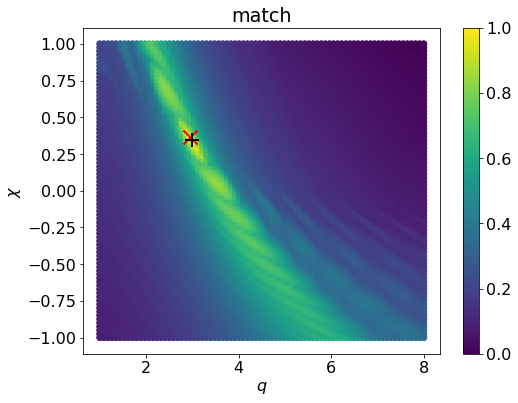

In [386]:
plt.figure(figsize=(8,6))
plt.scatter(qq, cc, c=matches)
plt.scatter(qq[max_match_idx], cc[max_match_idx], s=200, lw=2, marker='x', c='r')
plt.scatter(q_true, chi_true, s=200, lw=2, marker='+', c='k')
plt.colorbar()
plt.xlabel(r'$q$')
plt.ylabel(r'$\chi$')
plt.title("match")

In [387]:
true_sur_hp, true_sur_hc, true_samp, true_sphase, true_sur_times = wave_sur_many(q_true, chi_true, amp_model, amp_basis, phase_model, phase_basis, true_ts_times)

In [388]:
print("best the model can really do:")
np.max(np.abs(match(true_ts_hp, true_sur_hp[0], true_ts_times)))

best the model can really do:


0.9999473821525776

(-100, 100)

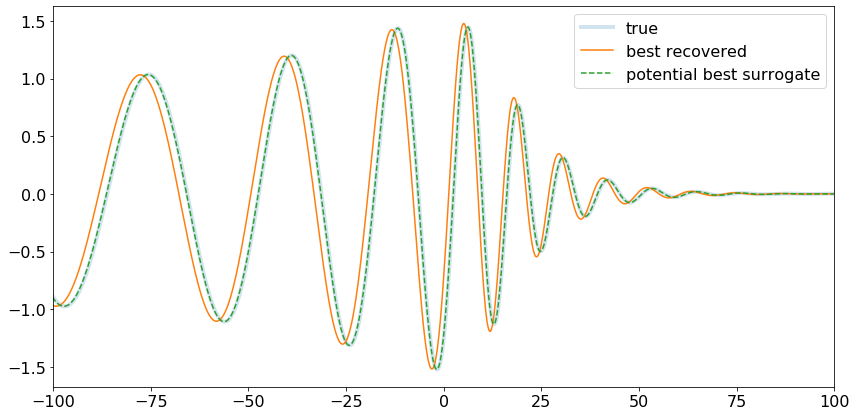

In [389]:
plt.figure(figsize=(14, 7))
plt.plot(true_ts_times, true_ts_hp, label='true', lw=4, alpha=0.2)
plt.plot(true_ts_times, sur_hp[max_match_idx], label='best recovered')
plt.plot(true_ts_times, true_sur_hp[0], label='potential best surrogate', ls='--')

plt.legend()
plt.xlim(-100,100)